Copyright (c) 2024 Massachusetts Institute of Technology

SPDX-License-Identifier: MIT

# Example 4: Satellite Maneuvers
Whether it's with a brief, powerful chemical thrust or a slow-and-steady electric propulsion, a maneuvering satellite can drastically change its orbit.

With `madlib`, we can add both impulsive and continuous maneuvers to satellites in order to simulate these effects.

## Impulsive Maneuvers
The most common type of maneuver is *impulsive*: a chemical burn that significantly changes the velocity of the satellite in a short amount of time. Here, "short" is relative to the period of the satellite's orbit. An object in GEO could burn for 10 minutes, but since its period is 24 hours, we can simplify the physics by treating that maneuver as an instantaneous change in velocity.

The first step to making a satellite with an impulsive maneuver in `madlib` is to make the satellite itself. We'll use a GEO object in this example:

In [1]:
import madlib

epoch_mjd = 60197.5
impulse_satellite = madlib.Satellite.from_GEO_longitude(lon=0.0, epoch=epoch_mjd)

Next we'll define the maneuver, which is a 3-element `numpy` array of delta-v values (changes in speed) in the [RIC satellite body frame](https://ai-solutions.com/_help_Files/attitude_reference_frames.htm#achr_ric). Each delta-v is in units of **km/s**.

We'll give our satellite an impulsive thrust of 0.0 km/s in the radial direction, 0.5 km/s in the in-track direction, and 0.1 km/s in the cross-track direction.

We also have to define the time at which the maneuver will occur in MJD format. We'll burn 72 hours past the orbital epoch.

In [2]:
import numpy as np

delta_v = np.array([0.0, 0.5, 0.1])  # RIC: Radial, In-track, Cross-track (all in km/s)
mnvr_time_mjd = epoch_mjd + 3.0

mnvr = madlib.ImpulsiveManeuver(time=mnvr_time_mjd, dv=delta_v)

With the `ImpulsiveManeuver` object created, we just have to add it to our satellite.

In [3]:
impulse_satellite.maneuver = mnvr

Now let's see what happens when we propagate the satellite for a full 96 hours, starting 48 hours before the maneuver

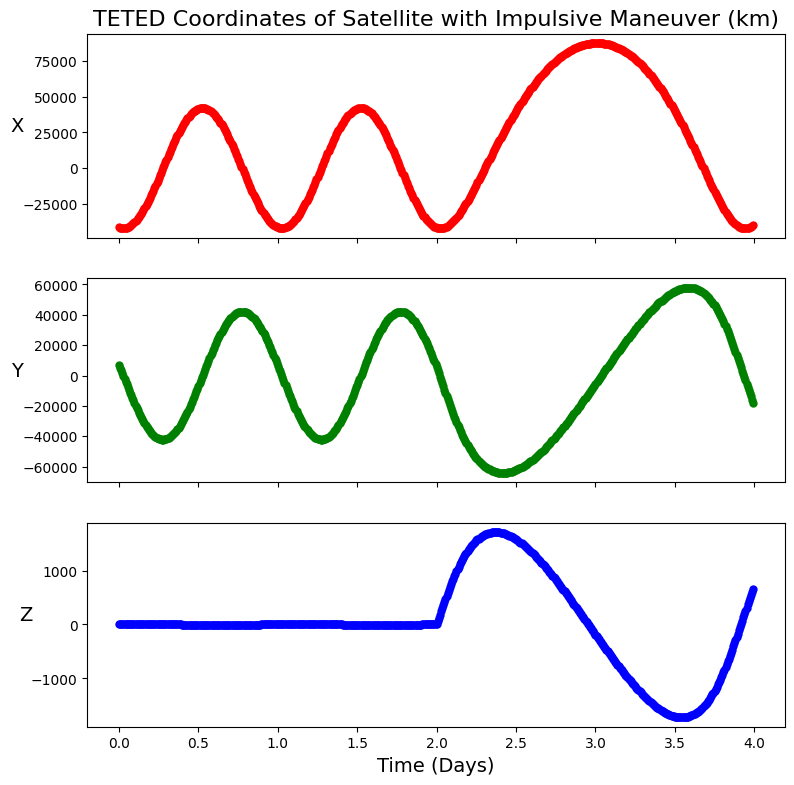

In [4]:
start_mjd = epoch_mjd + 1.0
end_mjd = start_mjd + 4
dt = 10.0 / 60 / 24  # Report the position every 10 minutes, converted into days

obs_times_mjd = np.arange(start_mjd, end_mjd, dt)

pos, vel = impulse_satellite.propagate(obs_times_mjd)

from matplotlib import pyplot as plt
%matplotlib inline

x = pos[:, 0]
y = pos[:, 1]
z = pos[:, 2]
t = obs_times_mjd - obs_times_mjd[0]
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(9, 9))
ax1.plot(t, x, "-or", ms=5, lw=2)
ax2.plot(t, y, "-og", ms=5, lw=2)
ax3.plot(t, z, "-ob", ms=5, lw=2)
plt.xlabel("Time (Days)", fontsize=14)
ax1.set(ylabel="X", title=f"TETED Coordinates of Satellite with Impulsive Maneuver (km)")
ax1.title.set_fontsize(16)
ax1.yaxis.label.set_fontsize(14)
ax1.yaxis.label.set_rotation(0)
ax2.set(ylabel="Y")
ax2.yaxis.label.set_fontsize(14)
ax2.yaxis.label.set_rotation(0)
ax3.set(ylabel="Z")
ax3.yaxis.label.set_fontsize(14)
ax3.yaxis.label.set_rotation(0)

Just as expected, we see a huge change in the satellite's motion at the 48-hour mark, right when the maneuver occurs. Try out maneuvers in different directions to see how they affect the orbit.

A maneuvering satellite can also be observed with a sensor or network of sensors as in previous example notebooks.

## Continuous Maneuvers
Recently, satellites that use electric propulsion have become more common. These provide relatively slow - but continuous - thrusts that can change an orbit over long periods of time.

`madlib` allows us to simulate these maneuvers in a similar manner to the impulsive case. However, we have to use a special class, `ContinuousThrustSatellite`, instead of the regular `Satellite` class we've been using in previous examples.

In [5]:
epoch_mjd = 60197.5
continuous_satellite = madlib.ContinuousThrustSatellite.from_GEO_longitude(
    lon=0.0, epoch=epoch_mjd
)

Next, we have to define our thrust vector as a function that will take in a time (formatted as a float) and return a 3-element `numpy` array representing the acceleration in the RIC frame (in units of km/s^2).

Our example will make a constant thrust of 1e-5 km/s^2 in the In-track direction.

In [6]:
accel_vec = [0, 1e-5, 0]


def acc_f(t):
    return accel_vec

We also have to define the start and stop times of the maneuver (in MJD format). We'll start burning at 72 hours past the orbital epoch and continue burning for 12 hours.

With the acceleration function and maneuver times, we can create the maneuver object and add it to our satellite.

In [7]:
mnvr_start = epoch_mjd + 3.0
mnvr_end = mnvr_start + 0.5

continuous_mnvr = madlib.ContinuousManeuver(f=acc_f, time_range=(mnvr_start, mnvr_end))

continuous_satellite.maneuver = continuous_mnvr

Let's see what this scenario looks like! We'll observe for the same timeframe as the example above. The effect will be more subtle than the impulsive case, so we'll also plot the maneuver-less orbit as dashed lines for comparison.

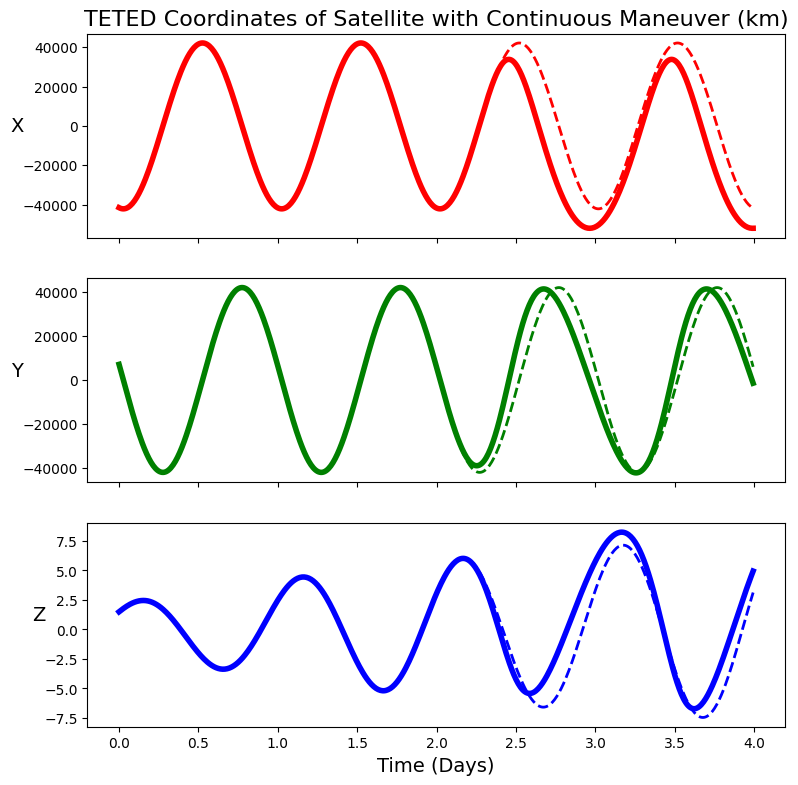

In [8]:
comparison_satellite = madlib.Satellite.from_GEO_longitude(lon=0.0, epoch=epoch_mjd)

start_mjd = epoch_mjd + 1.0
end_mjd = start_mjd + 4
dt = 10.0 / 60 / 24  # Report the position every 10 minutes, converted into days

obs_times_mjd = np.arange(start_mjd, end_mjd, dt)

pos, vel = continuous_satellite.propagate(obs_times_mjd)
pos_compare, vel_compare = comparison_satellite.propagate(obs_times_mjd)

x = pos[:, 0]
y = pos[:, 1]
z = pos[:, 2]
t = obs_times_mjd - obs_times_mjd[0]

xc = pos_compare[:, 0]
yc = pos_compare[:, 1]
zc = pos_compare[:, 2]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(9, 9))
ax1.plot(t, x, "-r", lw=4)
ax1.plot(t, xc, "--r", lw=2)
ax2.plot(t, y, "-g", lw=4)
ax2.plot(t, yc, "--g", lw=2)
ax3.plot(t, z, "-b", lw=4)
ax3.plot(t, zc, "--b", lw=2)
plt.xlabel("Time (Days)", fontsize=14)
ax1.set(
    ylabel="X", title=f"TETED Coordinates of Satellite with Continuous Maneuver (km)"
)
ax1.title.set_fontsize(16)
ax1.yaxis.label.set_fontsize(14)
ax1.yaxis.label.set_rotation(0)
ax2.set(ylabel="Y")
ax2.yaxis.label.set_fontsize(14)
ax2.yaxis.label.set_rotation(0)
ax3.set(ylabel="Z")
ax3.yaxis.label.set_fontsize(14)
ax3.yaxis.label.set_rotation(0)

In the future, we plan to expand upon the continuous maneuvering capabilities of `madlib` so that the thrust can be turned on and off multiple times according to a schedule or duty cycle.